In [2]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
plt.style.use('ggplot')
figsize=(18, 10)

In [3]:
import base64
import datetime
import hashlib
import hmac
import json
import urllib
import urllib.parse
import urllib.request
import requests

# 此处填写APIKEY

ACCESS_KEY = "fb5335bd-b1902e32-cc0b36e2-6850a"
SECRET_KEY = "49761a11-c8c3b8d3-e3639666-6a6c4"



# API 请求地址
MARKET_URL = "https://api.huobi.pro"
TRADE_URL = "https://api.huobi.pro"

# 首次运行可通过get_accounts()获取acct_id,然后直接赋值,减少重复获取。
ACCOUNT_ID = None

#'Timestamp': '2017-06-02T06:13:49'

def http_get_request(url, params, add_to_headers=None):
    headers = {
        "Content-type": "application/x-www-form-urlencoded",
        'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.71 Safari/537.36',
    }
    if add_to_headers:
        headers.update(add_to_headers)
    postdata = urllib.parse.urlencode(params)
    response = requests.get(url, postdata, headers=headers, timeout=10) 
    try:
        
        if response.status_code == 200:
            return response.json()
        else:
            return
    except BaseException as e:
        print("httpGet failed, detail is:%s,%s" %(response.text,e))
        return


def http_post_request(url, params, add_to_headers=None):
    headers = {
        "Accept": "application/json",
        'Content-Type': 'application/json'
    }
    if add_to_headers:
        headers.update(add_to_headers)
    postdata = json.dumps(params)
    response = requests.post(url, postdata, headers=headers, timeout=10)
    try:
        
        if response.status_code == 200:
            return response.json()
        else:
            return
    except BaseException as e:
        print("httpPost failed, detail is:%s,%s" %(response.text,e))
        return


def api_key_get(params, request_path):
    method = 'GET'
    timestamp = datetime.datetime.utcnow().strftime('%Y-%m-%dT%H:%M:%S')
    params.update({'AccessKeyId': ACCESS_KEY,
                   'SignatureMethod': 'HmacSHA256',
                   'SignatureVersion': '2',
                   'Timestamp': timestamp})

    host_url = TRADE_URL
    host_name = urllib.parse.urlparse(host_url).hostname
    host_name = host_name.lower()
    params['Signature'] = createSign(params, method, host_name, request_path, SECRET_KEY)

    url = host_url + request_path
    return http_get_request(url, params)


def api_key_post(params, request_path):
    method = 'POST'
    timestamp = datetime.datetime.utcnow().strftime('%Y-%m-%dT%H:%M:%S')
    params_to_sign = {'AccessKeyId': ACCESS_KEY,
                      'SignatureMethod': 'HmacSHA256',
                      'SignatureVersion': '2',
                      'Timestamp': timestamp}

    host_url = TRADE_URL
    host_name = urllib.parse.urlparse(host_url).hostname
    host_name = host_name.lower()
    params_to_sign['Signature'] = createSign(params_to_sign, method, host_name, request_path, SECRET_KEY)
    url = host_url + request_path + '?' + urllib.parse.urlencode(params_to_sign)
    return http_post_request(url, params)


def createSign(pParams, method, host_url, request_path, secret_key):
    sorted_params = sorted(pParams.items(), key=lambda d: d[0], reverse=False)
    encode_params = urllib.parse.urlencode(sorted_params)
    payload = [method, host_url, request_path, encode_params]
    payload = '\n'.join(payload)
    payload = payload.encode(encoding='UTF8')
    secret_key = secret_key.encode(encoding='UTF8')

    digest = hmac.new(secret_key, payload, digestmod=hashlib.sha256).digest()
    signature = base64.b64encode(digest)
    signature = signature.decode()
    return signature

In [4]:
'''
Market data API
'''


# 获取KLine
def get_kline(symbol, period, size=150):
    """
    :param symbol
    :param period: 可选值：{1min, 5min, 15min, 30min, 60min, 1day, 1mon, 1week, 1year }
    :param size: 可选值： [1,2000]
    :return:
    """
    params = {'symbol': symbol,
              'period': period,
              'size': size}

    url = MARKET_URL + '/market/history/kline'
    return http_get_request(url, params)


# 获取marketdepth
def get_depth(symbol, type):
    """
    :param symbol
    :param type: 可选值：{ percent10, step0, step1, step2, step3, step4, step5 }
    :return:
    """
    params = {'symbol': symbol,
              'type': type}
    
    url = MARKET_URL + '/market/depth'
    return http_get_request(url, params)


# 获取tradedetail
def get_trade(symbol):
    """
    :param symbol
    :return:
    """
    params = {'symbol': symbol}

    url = MARKET_URL + '/market/trade'
    return http_get_request(url, params)


# 获取merge ticker
def get_ticker(symbol):
    """
    :param symbol: 
    :return:
    """
    params = {'symbol': symbol}

    url = MARKET_URL + '/market/detail/merged'
    return http_get_request(url, params)


# 获取 Market Detail 24小时成交量数据
def get_detail(symbol):
    """
    :param symbol
    :return:
    """
    params = {'symbol': symbol}

    url = MARKET_URL + '/market/detail'
    return http_get_request(url, params)

# 获取  支持的交易对
def get_symbols(long_polling=None):
    """
    """
    params = {}
    if long_polling:
        params['long-polling'] = long_polling
    path = '/v1/common/symbols'
    return api_key_get(params, path)

'''
Trade/Account API
'''


def get_accounts():
    """
    :return: 
    """
    path = "/v1/account/accounts"
    params = {}
    return api_key_get(params, path)

ACCOUNT_ID = 0
# 获取当前账户资产
def get_balance(acct_id=None):
    """
    :param acct_id
    :return:
    """
    global ACCOUNT_ID
    
    if not acct_id:
        accounts = get_accounts()
        acct_id = accounts['data'][0]['id'];

    url = "/v1/account/accounts/{0}/balance".format(acct_id)
    params = {"account-id": acct_id}
    return api_key_get(params, url)


# 下单

# 创建并执行订单
def send_order(amount, source, symbol, _type, price=0):
    """
    :param amount: 
    :param source: 如果使用借贷资产交易，请在下单接口,请求参数source中填写'margin-api'
    :param symbol: 
    :param _type: 可选值 {buy-market：市价买, sell-market：市价卖, buy-limit：限价买, sell-limit：限价卖}
    :param price: 
    :return: 
    """
    try:
        accounts = get_accounts()
        acct_id = accounts['data'][0]['id']
    except BaseException as e:
        print ('get acct_id error.%s' % e)
        acct_id = ACCOUNT_ID

    params = {"account-id": acct_id,
              "amount": amount,
              "symbol": symbol,
              "type": _type,
              "source": source}
    if price:
        params["price"] = price

    url = '/v1/order/orders/place'
    return api_key_post(params, url)


# 撤销订单
def cancel_order(order_id):
    """
    
    :param order_id: 
    :return: 
    """
    params = {}
    url = "/v1/order/orders/{0}/submitcancel".format(order_id)
    return api_key_post(params, url)


# 查询某个订单
def order_info(order_id):
    """
    
    :param order_id: 
    :return: 
    """
    params = {}
    url = "/v1/order/orders/{0}".format(order_id)
    return api_key_get(params, url)


# 查询某个订单的成交明细
def order_matchresults(order_id):
    """
    
    :param order_id: 
    :return: 
    """
    params = {}
    url = "/v1/order/orders/{0}/matchresults".format(order_id)
    return api_key_get(params, url)


# 查询当前委托、历史委托
def orders_list(symbol, states, types=None, start_date=None, end_date=None, _from=None, direct=None, size=None):
    """
    
    :param symbol: 
    :param states: 可选值 {pre-submitted 准备提交, submitted 已提交, partial-filled 部分成交, partial-canceled 部分成交撤销, filled 完全成交, canceled 已撤销}
    :param types: 可选值 {buy-market：市价买, sell-market：市价卖, buy-limit：限价买, sell-limit：限价卖}
    :param start_date: 
    :param end_date: 
    :param _from: 
    :param direct: 可选值{prev 向前，next 向后}
    :param size: 
    :return: 
    """
    params = {'symbol': symbol,
              'states': states}

    if types:
        params[types] = types
    if start_date:
        params['start-date'] = start_date
    if end_date:
        params['end-date'] = end_date
    if _from:
        params['from'] = _from
    if direct:
        params['direct'] = direct
    if size:
        params['size'] = size
    url = '/v1/order/orders'
    return api_key_get(params, url)


# 查询当前成交、历史成交
def orders_matchresults(symbol, types=None, start_date=None, end_date=None, _from=None, direct=None, size=None):
    """
    
    :param symbol: 
    :param types: 可选值 {buy-market：市价买, sell-market：市价卖, buy-limit：限价买, sell-limit：限价卖}
    :param start_date: 
    :param end_date: 
    :param _from: 
    :param direct: 可选值{prev 向前，next 向后}
    :param size: 
    :return: 
    """
    params = {'symbol': symbol}

    if types:
        params[types] = types
    if start_date:
        params['start-date'] = start_date
    if end_date:
        params['end-date'] = end_date
    if _from:
        params['from'] = _from
    if direct:
        params['direct'] = direct
    if size:
        params['size'] = size
    url = '/v1/order/matchresults'
    return api_key_get(params, url)



# 申请提现虚拟币
def withdraw(address, amount, currency, fee=0, addr_tag=""):
    """
    :param address_id: 
    :param amount: 
    :param currency:btc, ltc, bcc, eth, etc ...(火币Pro支持的币种)
    :param fee: 
    :param addr-tag:
    :return: {
              "status": "ok",
              "data": 700
            }
    """
    params = {'address': address,
              'amount': amount,
              "currency": currency,
              "fee": fee,
              "addr-tag": addr_tag}
    url = '/v1/dw/withdraw/api/create'

    return api_key_post(params, url)

# 申请取消提现虚拟币
def cancel_withdraw(address_id):
    """
    :param address_id: 
    :return: {
              "status": "ok",
              "data": 700
            }
    """
    params = {}
    url = '/v1/dw/withdraw-virtual/{0}/cancel'.format(address_id)

    return api_key_post(params, url)


'''
借贷API
'''

# 创建并执行借贷订单


def send_margin_order(amount, source, symbol, _type, price=0):
    """
    :param amount: 
    :param source: 'margin-api'
    :param symbol: 
    :param _type: 可选值 {buy-market：市价买, sell-market：市价卖, buy-limit：限价买, sell-limit：限价卖}
    :param price: 
    :return: 
    """
    try:
        accounts = get_accounts()
        acct_id = accounts['data'][0]['id']
    except BaseException as e:
        print ('get acct_id error.%s' % e)
        acct_id = ACCOUNT_ID

    params = {"account-id": acct_id,
              "amount": amount,
              "symbol": symbol,
              "type": _type,
              "source": 'margin-api'}
    if price:
        params["price"] = price

    url = '/v1/order/orders/place'
    return api_key_post(params, url)

# 现货账户划入至借贷账户


def exchange_to_margin(symbol, currency, amount):
    """
    :param amount: 
    :param currency: 
    :param symbol: 
    :return: 
    """
    params = {"symbol": symbol,
              "currency": currency,
              "amount": amount}

    url = "/v1/dw/transfer-in/margin"
    return api_key_post(params, url)

# 借贷账户划出至现货账户


def margin_to_exchange(symbol, currency, amount):
    """
    :param amount: 
    :param currency: 
    :param symbol: 
    :return: 
    """
    params = {"symbol": symbol,
              "currency": currency,
              "amount": amount}

    url = "/v1/dw/transfer-out/margin"
    return api_key_post(params, url)

# 申请借贷
def get_margin(symbol, currency, amount):
    """
    :param amount: 
    :param currency: 
    :param symbol: 
    :return: 
    """
    params = {"symbol": symbol,
              "currency": currency,
              "amount": amount}
    url = "/v1/margin/orders"
    return api_key_post(params, url)

# 归还借贷
def repay_margin(order_id, amount):
    """
    :param order_id: 
    :param amount: 
    :return: 
    """
    params = {"order-id": order_id,
              "amount": amount}
    url = "/v1/margin/orders/{0}/repay".format(order_id)
    return api_key_post(params, url)

# 借贷订单
def loan_orders(symbol, currency, start_date="", end_date="", start="", direct="", size=""):
    """
    :param symbol: 
    :param currency: 
    :param direct: prev 向前，next 向后
    :return: 
    """
    params = {"symbol": symbol,
              "currency": currency}
    if start_date:
        params["start-date"] = start_date
    if end_date:
        params["end-date"] = end_date
    if start:
        params["from"] = start
    if direct and direct in ["prev", "next"]:
        params["direct"] = direct
    if size:
        params["size"] = size
    url = "/v1/margin/loan-orders"
    return api_key_get(params, url)


# 借贷账户详情,支持查询单个币种
def margin_balance(symbol):
    """
    :param symbol: 
    :return: 
    """
    params = {}
    url = "/v1/margin/accounts/balance"
    if symbol:
        params['symbol'] = symbol
    
    return api_key_get(params, url)

In [4]:
symbols = get_symbols()
symbol_df = pd.DataFrame(symbols['data'])
symbol_df.sort_values(by=['symbol-partition'], ascending=False, inplace=True)
symbol_df.head()

,amount-precision,base-currency,price-precision,quote-currency,symbol,symbol-partition
0,4,btc,2,usdt,btcusdt,main
247,4,eos,6,ht,eosht,main
245,4,dash,6,ht,dashht,main
154,4,omg,6,eth,omgeth,main
243,4,xrp,6,ht,xrpht,main


In [5]:
def kline_plot(symbol, period):
    kline = get_kline(symbol, period)
    df = pd.DataFrame(kline['data'])
    df = df.set_index(keys=['id'])
    df.index = pd.to_datetime(df.index, unit='s')
    df.plot(y='close', figsize=figsize)
    return df

,amount,close,count,high,low,open,vol
id,,,,,,,
2018-07-15 16:00:00,5.802692e+05,0.001155,8121,0.001178,0.001141,0.001164,671.666937
2018-07-14 16:00:00,1.529587e+06,0.001163,19190,0.001169,0.001099,0.001111,1707.569411
2018-07-13 16:00:00,1.511809e+06,0.001111,19373,0.001133,0.001084,0.001129,1673.714578
2018-07-12 16:00:00,1.803062e+06,0.001129,20266,0.001160,0.001079,0.001094,2022.868277
2018-07-11 16:00:00,1.571447e+06,0.001095,21611,0.001125,0.001061,0.001107,1718.095195


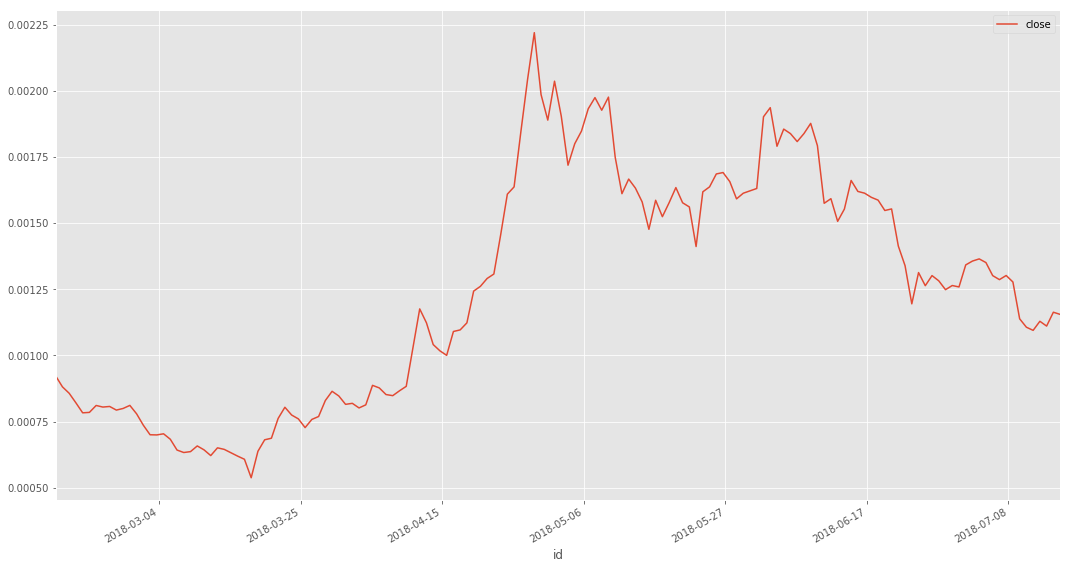

In [6]:
eosbtc_1d_df = kline_plot('eosbtc', '1day')
eosbtc_1d_df.head()

In [ ]:
eosbtc_1d_df = kline_plot('eosbtc', '24h')

In [40]:
get_detail('btcusdt')

{'ch': 'market.btcusdt.detail',
 'status': 'ok',
 'tick': {'amount': 17876.096272860777,
  'close': 6373.61,
  'count': 196808,
  'high': 6586.2,
  'id': 12065807349,
  'low': 6270.0,
  'open': 6584.95,
  'version': 12065807349,
  'vol': 113895422.37666602},
 'ts': 1531299638729}

In [56]:
def get_main_detail(df):
    main_df = df[df['symbol-partition'] == 'main']
    main_details = []
    for index, row in main_df.iterrows():
        symbol = row['symbol']
        print(symbol)
        res = get_detail(symbol)
        tick = res['tick']
        tick['symbol'] = symbol
        tick['base-currency'] = row['base-currency']
        main_details.append(tick)
    return pd.DataFrame(main_details)

In [54]:
main_detail_df = get_main_detail(symbol_df)

In [55]:
main_detail_df

,amount,base-currency,close,count,high,id,low,open,symbol,version,vol
0,1.771547e+04,btc,6346.670000,195176,6542.520000,12067771682,6270.000000,6541.970000,btcusdt,12067771682,1.127670e+08
1,4.886641e+05,eos,2.231054,18490,2.378900,12067772843,2.230001,2.329045,eosht,12067772843,1.124622e+06
2,9.047061e+02,dash,69.940930,23068,74.014888,12067775369,67.039172,68.118607,dashht,12067775369,6.347679e+04
3,1.452567e+05,omg,0.015499,7623,0.016312,12067771764,0.014660,0.015653,omgeth,12067771764,2.292634e+03
4,6.621792e+05,xrp,0.142633,6910,0.150379,12067746248,0.137937,0.140050,xrpht,12067746248,9.430826e+04
5,3.656882e+04,bch,692.050000,39196,718.320000,12067769643,681.380000,718.090000,bchusdt,12067769643,2.540399e+07
6,1.246326e+05,iota,0.002223,10719,0.002258,12067776615,0.002171,0.002176,iotaeth,12067776615,2.772598e+02
7,8.876216e+04,steem,0.002983,11955,0.003289,12067785959,0.002800,0.003066,steemeth,12067785959,2.663359e+02
8,8.312415e+02,xmr,0.020056,8364,0.020067,12067780765,0.019067,0.019428,xmrbtc,12067780765,1.617931e+01
9,7.425364e+03,bch,0.109031,13188,0.110714,12067766321,0.108585,0.109848,bchbtc,12067766321,8.098469e+02


# Volumes of symbols for the last 24H

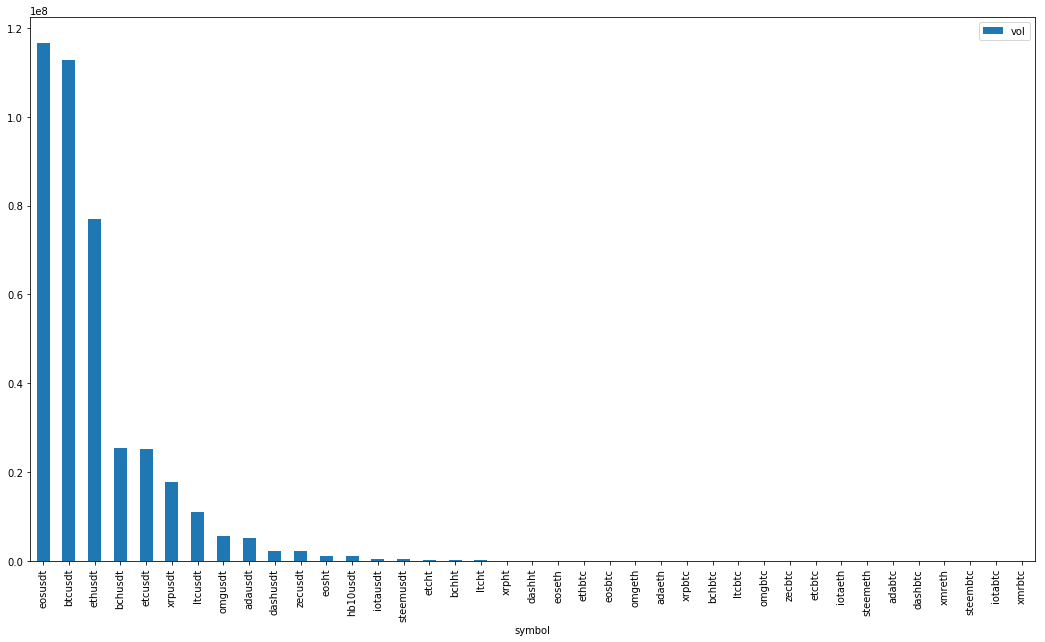

In [71]:
main_detail_df.sort_values(by='vol', ascending=False).plot(figsize=figsize, kind='bar', x='symbol', y='vol')

# Amount of symbols for the last 24H

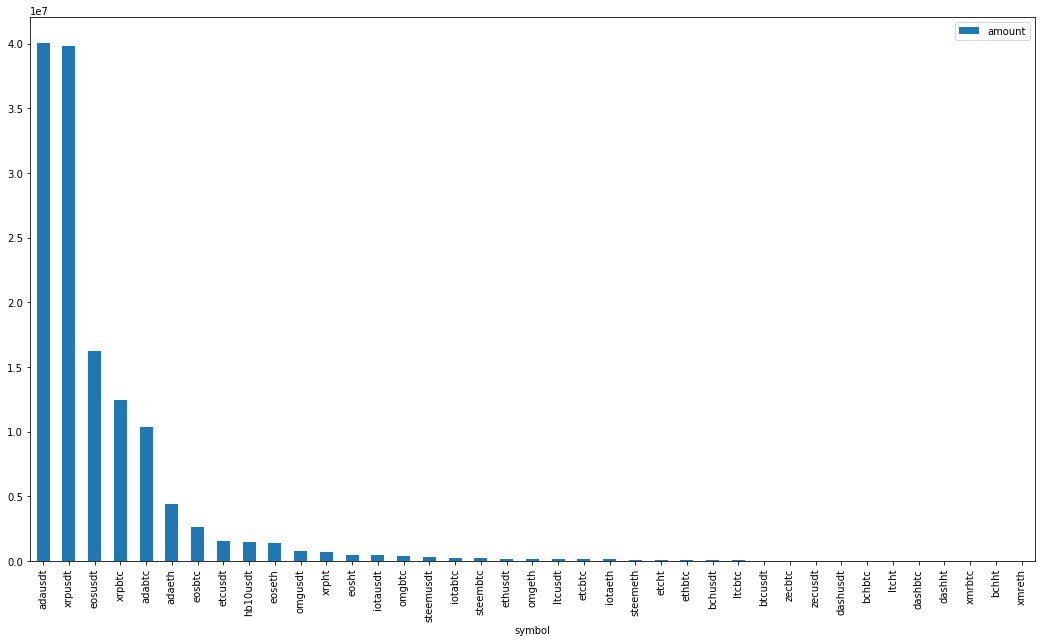

In [72]:
main_detail_df.sort_values(by='amount', ascending=False).plot(figsize=figsize, kind='bar', x='symbol', y='amount')

# Volumes for the last 24H

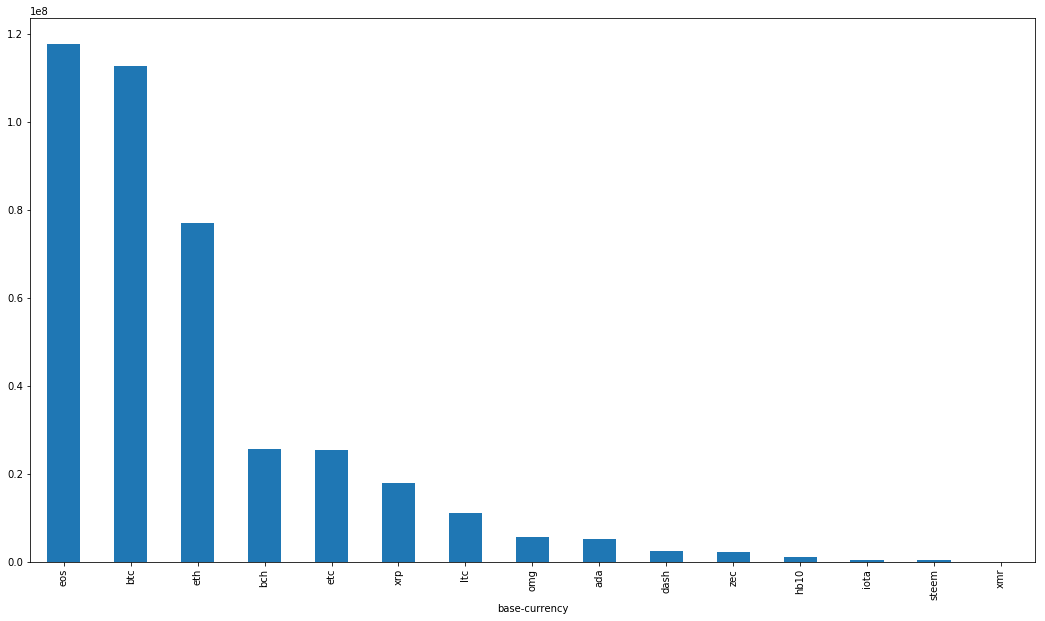

In [67]:
volumes = main_detail_df.groupby(['base-currency'])['vol'].sum()
volumes
volumes.sort_values(ascending=False).plot(figsize=figsize, kind='bar')

In [139]:
btcusdt_60min_kline = get_kline('btcusdt', '60min', 14*24)
btcusdt_60min_kline_df = pd.DataFrame(btcusdt_60min_kline['data'])
btcusdt_60min_kline_df.head()

,amount,close,count,high,id,low,open,vol
0,594.132429,6468.62,4917,6473.79,1531731600,6372.85,6375.22,3.824338e+06
1,507.350122,6375.23,6468,6410.00,1531728000,6360.00,6368.34,3.234831e+06
2,367.146226,6368.35,5856,6380.21,1531724400,6364.76,6373.57,2.339392e+06
3,326.084063,6373.42,4782,6387.34,1531720800,6365.46,6367.02,2.078300e+06
4,303.639457,6367.01,3750,6369.43,1531717200,6349.50,6350.98,1.931974e+06


In [8]:
import datetime
def toHour(id):
    return datetime.datetime.fromtimestamp(id).hour

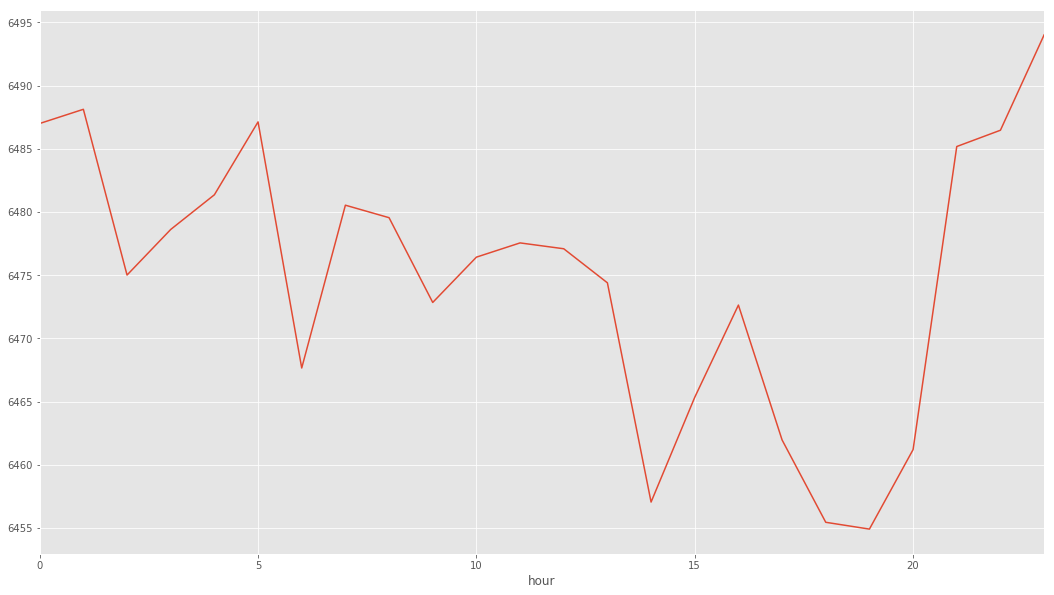

In [141]:
hour_grp_close_mean = btcusdt_60min_kline_df.groupby(['hour'])['close'].mean()
hour_grp_close_mean.plot(figsize=figsize, kind='line')

In [142]:
btcusdt_60min_kline_df.groupby(['hour'])['close'].mean()

hour
0     6487.000714
1     6488.123571
2     6475.009286
3     6478.616429
4     6481.360000
5     6487.127857
6     6467.655000
7     6480.537143
8     6479.547857
9     6472.841429
10    6476.425714
11    6477.552857
12    6477.090000
13    6474.394286
14    6457.047143
15    6465.337857
16    6472.634286
17    6461.962857
18    6455.447143
19    6454.909286
20    6461.199286
21    6485.178571
22    6486.467857
23    6494.010000
Name: close, dtype: float64

In [143]:
buy_fee = 0.002
sell_fee = 0.002

# Day trading strategy
Buy at the hour with min close price, and sell at hour with max close price every single day.

In [5]:
def day_trade_strategy(symbol, size, principle):
    kline = get_kline(symbol, '60min', size)
    df = pd.DataFrame(kline['data'])

    hours = df['id'].apply(toHour)
    df['hour'] = hours
    df.sort_values(by=['id'], inplace=True)
    hour_grp_close_mean = df.groupby(['hour'])['close'].mean()
    print(hour_grp_close_mean)
    buy_hour = hour_grp_close_mean.idxmin()
    sell_hour = hour_grp_close_mean.idxmax()
    first = True
    buy_points = []
    sell_points = []
    fee = 0
    for index, row in df.iterrows():
        hour = row['hour']
        if hour == buy_hour:
            buy_points.append(row['close'])
            first = False
        elif hour == sell_hour:
            if first == False:
                sell_points.append(row['close'])
    min_len = min(len(buy_points), len(sell_points))
    buy_points = buy_points[0:min_len-1]
    sell_points = sell_points[0:min_len-1]
    bull_sell_zip = zip(buy_points, sell_points)
    x = [i for i in range(min_len-1)]
    plt.yscale('linear')
    plt.rcParams["figure.figsize"] = (20,10)
    plt.plot(x, buy_points, 'green')
    plt.plot(x, sell_points, 'red')
    plt.show()
    p = principle
    for pair in list(bull_sell_zip):
        b = pair[0]
        s = pair[1]
        base = round(p * (1 - buy_fee) / b, 4)
        p = s * base * (1-buy_fee)
    roi = round(p/principle, 4)
    return buy_hour, sell_hour, p, roi
    

In [6]:
day_trade_strategy('btcusdt', 200, 10000)

NameError: name 'toHour' is not defined

hour
0     12.180842
1     12.186914
2     12.201965
3     12.199893
4     12.201980
5     12.180243
6     12.162451
7     12.177688
8     12.152600
9     12.174892
10    12.171886
11    12.120426
12    12.105636
13    12.059648
14    12.047952
15    12.034773
16    12.053676
17    12.072693
18    12.094068
19    12.134402
20    12.142007
21    12.127329
22    12.136454
23    12.171122
Name: close, dtype: float64


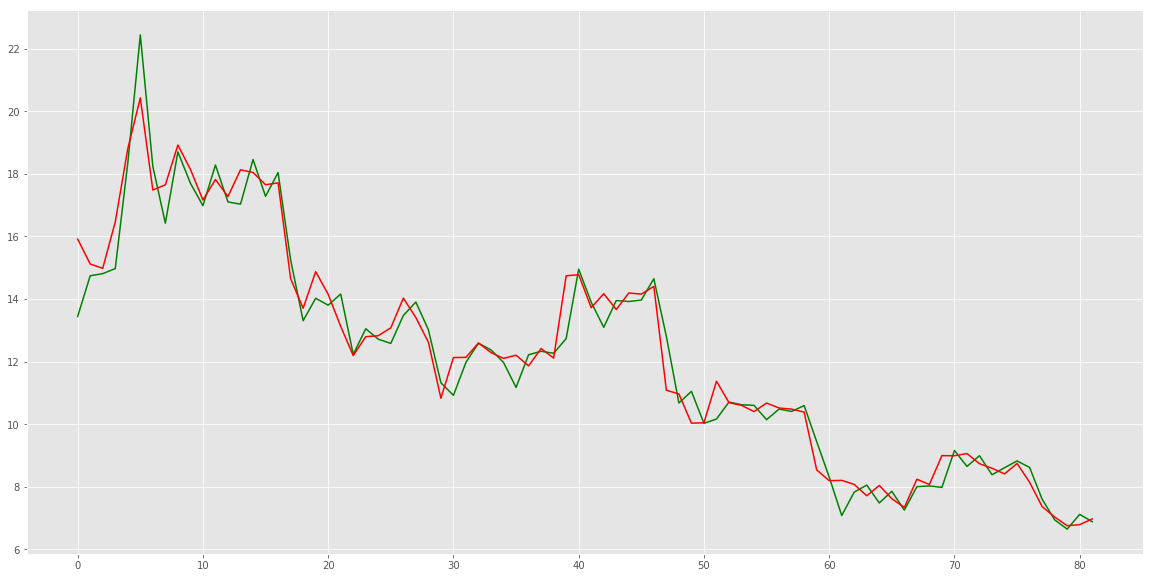

(15, 4, 14502.337860276801, 1.4501999999999999)

In [165]:
day_trade_strategy('eosusdt', 2000, 10000)

hour
0     0.001583
1     0.001584
2     0.001587
3     0.001586
4     0.001587
5     0.001586
6     0.001583
7     0.001585
8     0.001585
9     0.001586
10    0.001586
11    0.001579
12    0.001576
13    0.001571
14    0.001570
15    0.001569
16    0.001571
17    0.001574
18    0.001576
19    0.001580
20    0.001580
21    0.001579
22    0.001580
23    0.001583
Name: close, dtype: float64


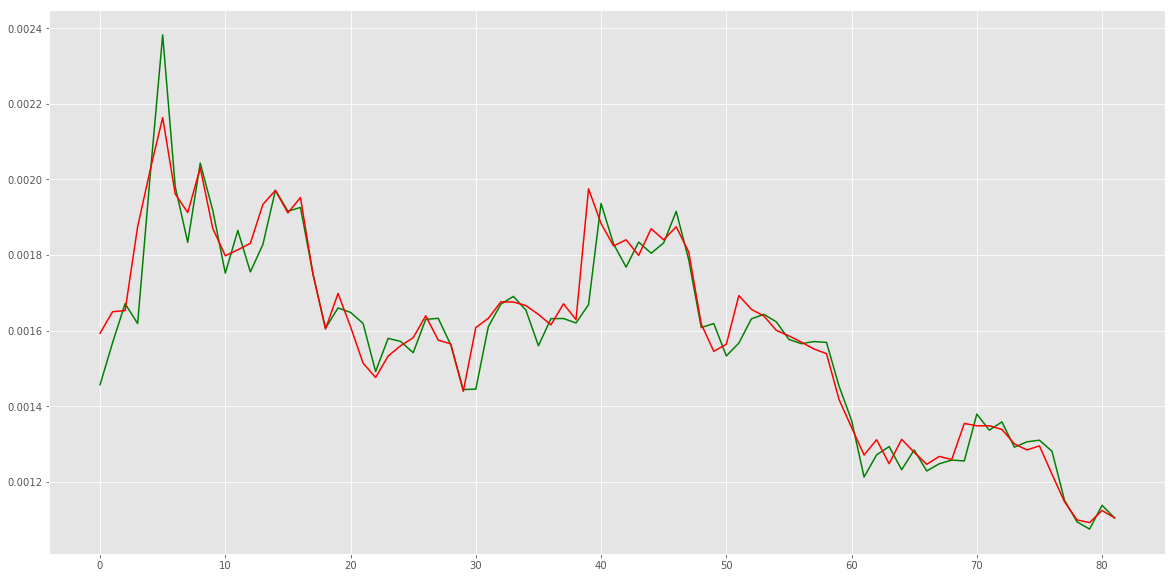

(15, 2, 13942.213540317185, 1.3942000000000001)

In [166]:
day_trade_strategy('eosbtc', 2000, 10000)

hour
0     0.002289
1     0.002290
2     0.002288
3     0.002288
4     0.002289
5     0.002288
6     0.002288
7     0.002288
8     0.002291
9     0.002293
10    0.002290
11    0.002287
12    0.002286
13    0.002288
14    0.002286
15    0.002283
16    0.002283
17    0.002285
18    0.002288
19    0.002284
20    0.002284
21    0.002281
22    0.002283
23    0.002284
Name: close, dtype: float64


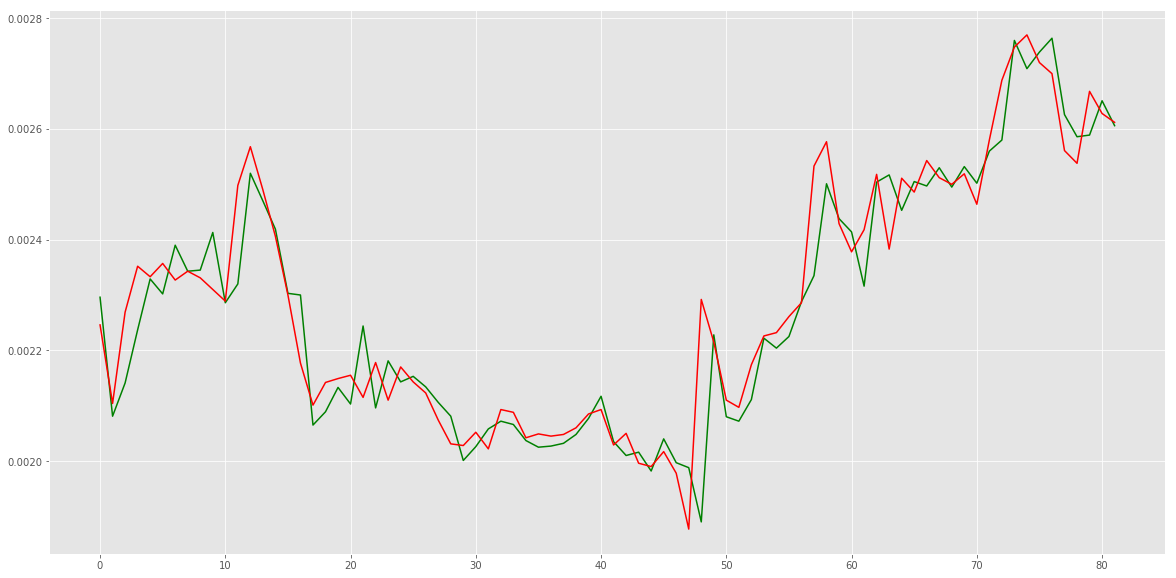

(21, 9, 11230.441170322698, 1.123)

In [167]:
day_trade_strategy('etcbtc', 2000, 10000)

hour
0     0.000023
1     0.000023
2     0.000023
3     0.000023
4     0.000023
5     0.000023
6     0.000023
7     0.000023
8     0.000023
9     0.000023
10    0.000023
11    0.000023
12    0.000023
13    0.000023
14    0.000023
15    0.000023
16    0.000023
17    0.000023
18    0.000023
19    0.000023
20    0.000023
21    0.000023
22    0.000023
23    0.000023
Name: close, dtype: float64


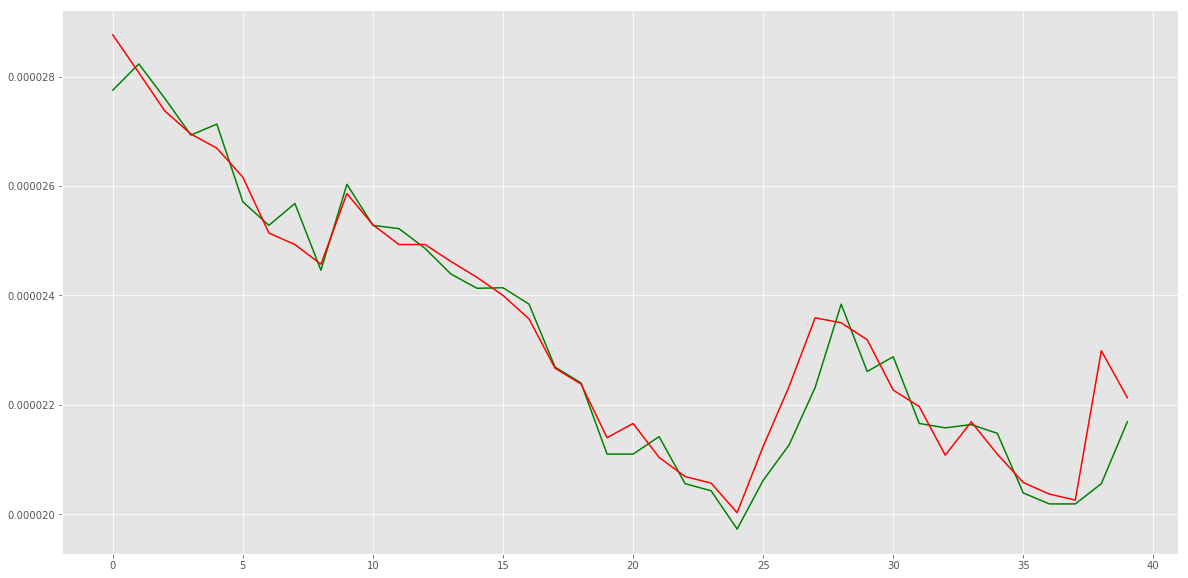

(15, 4, 11202.793724803969, 1.1203000000000001)

In [171]:
day_trade_strategy('adabtc', 1000, 10000)

hour
0     0.000313
1     0.000313
2     0.000314
3     0.000315
4     0.000316
5     0.000315
6     0.000315
7     0.000315
8     0.000314
9     0.000314
10    0.000314
11    0.000314
12    0.000313
13    0.000313
14    0.000312
15    0.000312
16    0.000313
17    0.000312
18    0.000312
19    0.000313
20    0.000312
21    0.000312
22    0.000312
23    0.000313
Name: close, dtype: float64


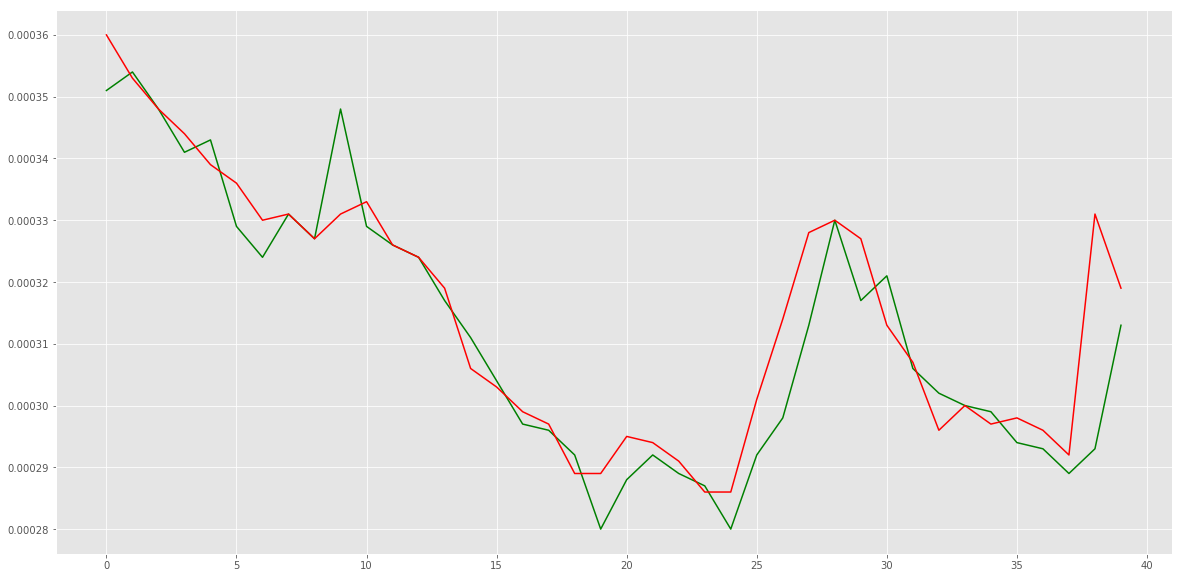

(15, 4, 12474.762946554407, 1.2475000000000001)

In [172]:
day_trade_strategy('adaeth', 1000, 10000)

hour
0     0.020667
1     0.020702
2     0.020737
3     0.020723
4     0.020749
5     0.020719
6     0.020684
7     0.020685
8     0.020678
9     0.020676
10    0.020669
11    0.020605
12    0.020561
13    0.020506
14    0.020491
15    0.020494
16    0.020527
17    0.020556
18    0.020570
19    0.020609
20    0.020595
21    0.020608
22    0.020626
23    0.020678
Name: close, dtype: float64


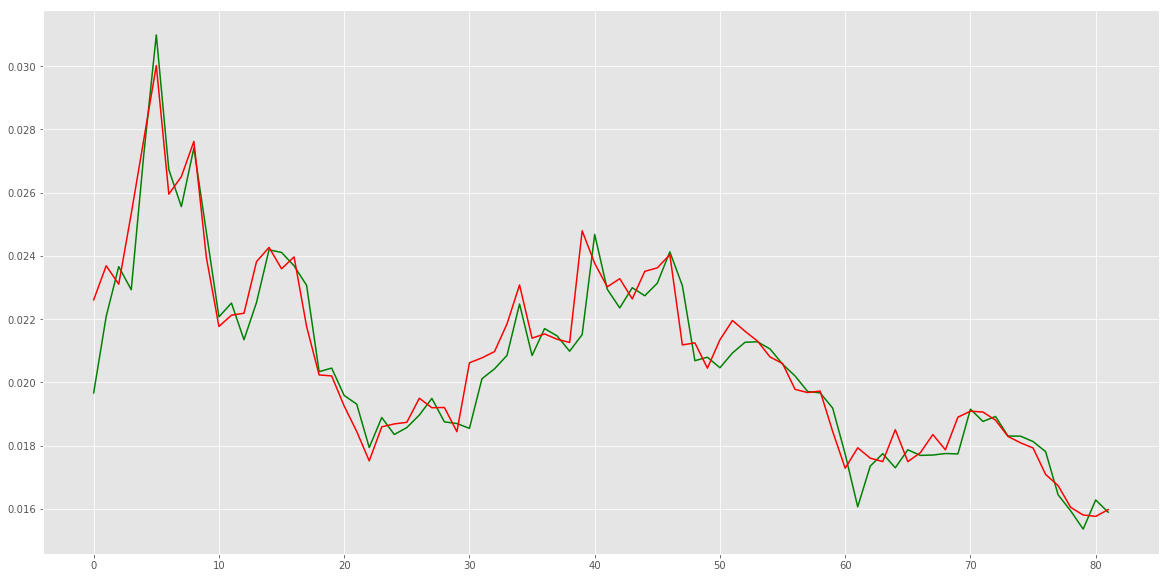

(14, 4, 16007.894117146023, 1.6008)

In [183]:
day_trade_strategy('eoseth', 2000, 10000)

hour
0     228.843000
1     228.022000
2     227.686000
3     227.853000
4     227.923000
5     227.635000
6     227.457000
7     228.369000
8     228.352000
9     227.868182
10    227.633636
11    230.231818
12    228.800909
13    228.592727
14    228.750000
15    228.406364
16    228.553636
17    228.710000
18    229.502727
19    228.723000
20    228.239000
21    228.400000
22    228.280000
23    228.571000
Name: close, dtype: float64


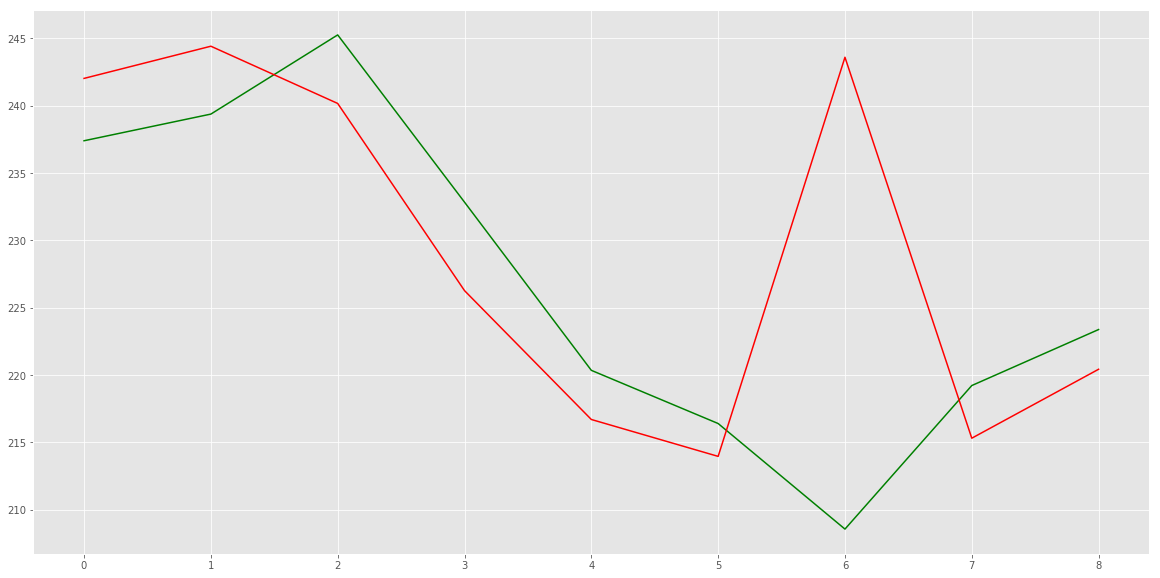

(6, 11, 10517.812776884, 1.0518000000000001)

In [188]:
day_trade_strategy('dashusdt', 250, 10000)

hour
0     0.035549
1     0.035394
2     0.035418
3     0.035431
4     0.035437
5     0.035354
6     0.035374
7     0.035421
8     0.035376
9     0.035199
10    0.035259
11    0.035685
12    0.035466
13    0.035449
14    0.035587
15    0.035486
16    0.035485
17    0.035554
18    0.035627
19    0.035616
20    0.035465
21    0.035496
22    0.035465
23    0.035474
Name: close, dtype: float64


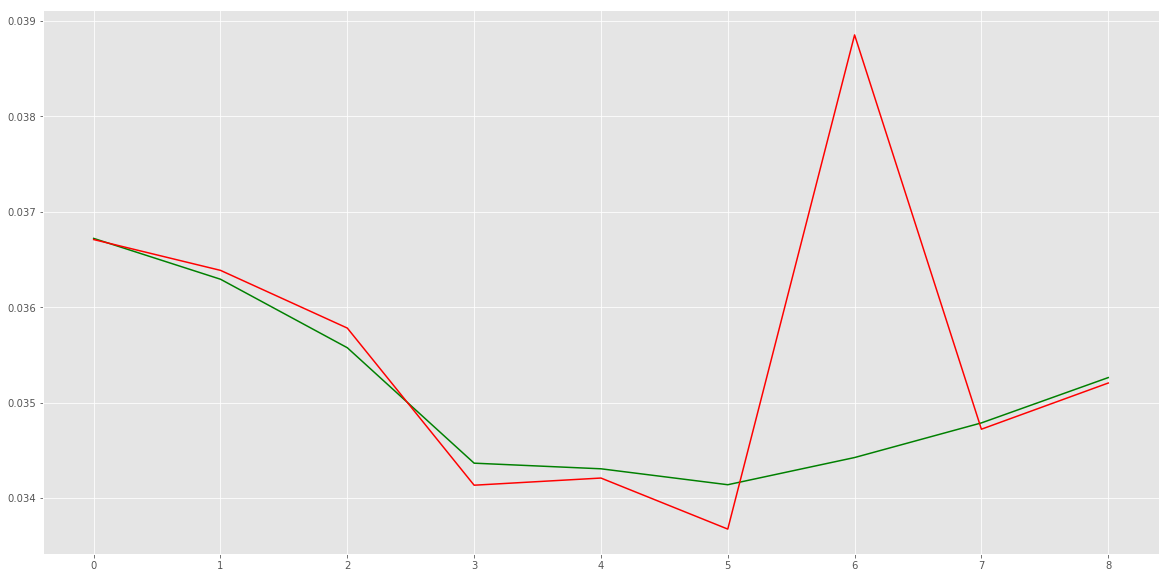

(9, 11, 10684.615808801438, 1.0685)

In [189]:
day_trade_strategy('dashbtc', 250, 10000)